<a name="top" id="top"></a>

<div align="center">
    <h1>Sensor placement and fault diagnosis in water distribution netwroks</h1>
    <a href="https://github.com/anurag-r20">Anurag Ramesh</a>
    <br>
    <i>Graduate Research Assistant</i>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <br>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Universities Space Research Association</i>
    <br>
    <i>NASA QuAIL</i>
    <br>
    <br>
    <a href="https://colab.research.google.com/github/SECQUOIA/QUBONotebooks/blob/main/notebooks_py/2-QUBO_python.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="#installation">
        <img src="https://img.shields.io/badge/⚙️-Installation_Instructions-blue" alt="Installation Instructions"/>
    </a>
    <a href="https://bernalde.github.io/">
        <img src="https://img.shields.io/badge/⚗️-Bernal_Lab-blue" alt="Bernal Lab"/>
    </a>
</div>

## Sensor Placement in Water Distribution Networks (WDN)

In this notebook, we formulate an optimization problem to identify the optimal placement of pressure sensors in a Water Distribution Network (WDN). The WDN is represented on a constrained graph $G(V,E)$, where $V$ is the set of vertices and $E$ is the set of edges.

We consider four different formulations of the optimization problem, including Mixed Integer Programming (MIP), Mixed Integer Quadratic Programming (MIQP), and Quadratic Unconstrained Binary Optimization (QUBO). The optimization problem is solved using three different solvers: Gurobi, Simulated Annealing, and D-Wave's implementation of Quantum Annealing via **[neal](https://github.com/dwavesystems/dwave-neal)**.

Additionally, we leverage D-Wave's package **[dwavebinarycsp](https://github.com/dwavesystems/dwavebinarycsp)** to translate constraint satisfaction problems into QUBOs. For Groebner basis computations, we use **[Sympy](https://www.sympy.org/)** for symbolic computation in Python and **[Networkx](https://networkx.github.io/)** for network models and graphs.

In [21]:
# If using this on Google collab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Let's install dimod, neal, and pyomo
if IN_COLAB:
    !pip install -q pyomo
    !pip install dimod
    !pip install dwave-neal

In [22]:
# Import the Pyomo library, which can be installed via pip, conda or from Github https://github.com/Pyomo/pyomo
import pyomo.environ as pyo
# Import the Dwave packages dimod and neal
import dimod
import neal
# Import Matplotlib to generate plots
import matplotlib.pyplot as plt
# Import numpy and scipy for certain numerical calculations below
import numpy as np
from scipy.special import gamma
import math
from collections import Counter
import pandas as pd
from itertools import chain
import time
# Import networkx for graph problems
import networkx as nx
from matplotlib.lines import Line2D

In [23]:
# Importing network data 

def WDN_network_data(city):
        
    # Apulian WDN 
    # Define the coordinates for the nodes
    node_coords_Ap = {
        "J-1": (1597.24, 1180),
        "J-2": (1432.13, 1340),
        "J-3": (745.9, 1346),
        "J-4": (921.33, 1124),
        "J-5": (1344.42, 1015),
        "J-6": (1086.44, 912),
        "J-7": (931.65, 804),
        "J-8": (828.45, 752),
        "J-9": (493.07, 1279),
        "J-10": (59.66, 1242),
        "J-11": (400.2, 1180),
        "J-12": (312.48, 917),
        "J-13": (54.5, 1015),
        "J-14": (1076.12, 443),
        "J-15": (1168.99, 448),
        "J-16": (1344.42, 494),
        "J-17": (1690.12, 592),
        "J-18": (1514.69, 799),
        "J-19": (1772.67, 861),
        "J-20": (1349.58, 25),
        "J-21": (1850.07, 283),
        "J-22": (487.91, 659),
        "J-23": (2020.34, 489),
        "T-1": (1860.39, 1181),
    }

    # Edges (Pipelines)
    edges_Ap = [
        ("J-1", "J-5"), ("J-1", "J-19"), ("J-2", "J-1"), ("J-2", "J-3"), ("J-2", "J-4"), ("J-3", "J-4"), ("J-4", "J-6"), ("J-9", "J-3"),
        ("J-5", "J-6"), ("J-6", "J-7"), ("J-7", "J-8"), ("J-8", "J-22"), ("J-8", "J-14"), ("J-7", "J-15"), ("J-6", "J-16"), ("J-10", "J-13"),
        ("J-9", "J-10"), ("J-10", "J-11"), ("J-11", "J-12"), ("J-12", "J-13"), ("J-13", "J-22"), ("J-11", "J-9"),
        ("J-14", "J-15"), ("J-15", "J-16"), ("J-16", "J-17"),
        ("J-17", "J-18"), ("J-17", "J-21"), ("J-18", "J-19"), ("J-19", "J-23"), ("J-20", "J-14"), ("J-20", "J-21"),
        ("J-21", "J-23"), ("T-1", "J-1"), ("J-5", "J-18")
    ]

    # Fossolo WDN
    # Define the coordinates for the nodes
    node_coords_Fo = {
        "J-1": (7111.65, 7532.36),
        "J-2": (5679.61, 9538.83),
        "J-3": (4862.46, 9538.83),
        "J-4": (2750.81, 9474.11),
        "J-5": (1852.75, 8357.61),
        "J-6": (1974.11, 6076.05),
        "J-7": (1974.11, 5149.68),
        "J-8": (4235.44, 5076.86),
        "J-9": (6411.81, 5093.04),
        "J-10": (5412.62, 7888.35),
        "J-11": (4510.52, 8264.56),
        "J-12": (3033.98, 9243.53),
        "J-13": (2301.78, 8078.48),
        "J-14": (2944.98, 7669.90),
        "J-15": (3786.41, 7139.97),
        "J-16": (4830.10, 6480.58),
        "J-17": (7099.51, 8438.51),
        "J-18": (5505.66, 8450.65),
        "J-19": (3563.92, 8839.00),
        "J-20": (3167.48, 7532.36),
        "J-21": (2730.58, 7285.60),
        "J-22": (3511.33, 6666.67),
        "J-23": (4097.90, 6286.41),
        "J-24": (3337.38, 5121.36),
        "J-25": (4530.74, 6011.33),
        "J-26": (4215.21, 7783.17),
        "J-27": (5194.17, 7055.02),
        "J-28": (5218.45, 5089.00),
        "J-29": (5622.98, 5999.19),
        "J-30": (5950.65, 5796.93),
        "J-31": (6614.08, 7621.36),
        "J-32": (5380.26, 7544.50),
        "J-33": (6318.77, 7281.55),
        "J-34": (6549.35, 7212.78),
        "J-35": (6585.76, 6092.23),
        "J-36": (7152.10, 6104.37),
        "T-1": (7669.90, 7783.17)
    }

    # Edges (Pipelines)
    edges_Fo = [
        ("J-1", "J-17"), ("J-17", "J-2"), ("J-2", "J-3"), ("J-3", "J-4"), ("J-4", "J-5"), ("J-5", "J-6"), ("J-6", "J-7"), ("J-7", "J-24"), ("J-24", "J-8"),
        ("J-8", "J-28"), ("J-28", "J-9"), ("J-9", "J-36"), ("J-36", "J-1"), ("J-1", "J-31"), ("J-31", "J-10"), ("J-10", "J-11"), ("J-11", "J-19"),
        ("J-19", "J-12"), ("J-12", "J-4"), ("J-2", "J-18"), ("J-18", "J-10"), ("J-10", "J-32"), ("J-32", "J-27"), ("J-27", "J-16"), ("J-16", "J-25"),
        ("J-25", "J-8"), ("J-3", "J-11"), ("J-11", "J-26"), ("J-26", "J-15"), ("J-15", "J-22"), ("J-22", "J-7"), ("J-5", "J-13"), ("J-13", "J-14"),
        ("J-14", "J-20"), ("J-20", "J-15"), ("J-15", "J-16"), ("J-16", "J-29"), ("J-29", "J-30"), ("J-30", "J-9"), ("J-17", "J-18"), ("J-12", "J-13"),
        ("J-19", "J-20"), ("J-14", "J-21"), ("J-21", "J-6"), ("J-21", "J-22"), ("J-22", "J-23"), ("J-24", "J-23"), ("J-23", "J-25"), ("J-26", "J-27"),
        ("J-28", "J-29"), ("J-29", "J-33"), ("J-32", "J-33"), ("J-33", "J-34"), ("J-31", "J-34"), ("J-34", "J-35"), ("J-30", "J-35"), ("J-35", "J-36"),
        ("T-1", "J-1")
    ]

    if city == "Apulian":
        return node_coords_Ap, edges_Ap
    elif city =="Fossolo":
        return node_coords_Fo, edges_Fo
    else: 
        return None, None


In [24]:
def Construct_Graph(city):
    coords, edges = WDN_network_data(city)

    if coords is None or edges is None:
        return None
    
    G = nx.Graph()

    # Defining Nodes in their coordinates
    for node, coord in coords.items():
        G.add_node(node, pos=coord)

    # Add edges
    G.add_edges_from(edges)

    return G   

In [25]:
def centrality(G, water_consumption):
    """
    
    """
    
    G = Construct_Graph(city)

    if G is None:
        return None, None

    # Calculating edge betweenness centrality
    edge_betweenness = nx.edge_betweenness_centrality(G)

    # Calculate degree centrality
    degree_centrality = nx.degree_centrality(G)

    # Edge betweenness centrality as weights
    for (u, v, d) in G.edges(data=True):
        d['weight'] = edge_betweenness[(u, v)]

    def normalized_demand(water_consumption):
        max_demand = max(water_consumption.values())
        return {node: val / max_demand for node, val in water_consumption.items()}

    normalized_demand = normalized_demand(water_consumption)

    # Define the weights C and D
    C = 1.0
    D = 1.0

    # Vertex cost function:
    vertex_cost = {}
    for node in G.nodes():
        f_i = normalized_demand[node]  # function of the water need at each node i
        g_i = degree_centrality[node]  # node weights
        vertex_cost[node] = C * f_i + D * g_i
    
    return vertex_cost, edge_betweenness 

In [26]:
######### Apulian WDN ####################################

# Create Graph:
city = "Apulian"
G_Ap = Construct_Graph(city)

# Water consumption at each node of Apulian WDN:
water_consumption_Ap = {
    "J-1": 10.863, "J-2": 117.034, "J-3": 14.947, "J-4": 14.8, "J-5": 10.133, "J-6": 13.35,
    "J-7": 9.114, "J-8": 10.51, "J-9": 12.182, "J-10": 14.579, "J-11": 9.007, "J-12": 7.575,
    "J-13": 15.2, "J-14": 13.55, "J-15": 9.226, "J-16": 11.2, "J-17": 11.469, "J-18": 10.818,
    "J-19": 14.675, "J-20": 13.318, "J-21": 14.631, "J-22": 12.012, "J-23": 10.326, "T-1": 10.863
}

################### Fossolo WDN ##########################
# Create Graph:
city = "Fossolo"
G_Fo = Construct_Graph(city)


# Water consumption at each node of Fossolo WDN: (Data not present)
water_consumption_Fo = {
    "J-1": 10.863, "J-2": 117.034, "J-3": 14.947, "J-4": 14.8, "J-5": 10.133, "J-6": 13.35,
    "J-7": 9.114, "J-8": 10.51, "J-9": 12.182, "J-10": 14.579, "J-11": 9.007, "J-12": 7.575,
    "J-13": 15.2, "J-14": 13.55, "J-15": 9.226, "J-16": 11.2, "J-17": 11.469, "J-18": 10.818,
    "J-19": 14.675, "J-20": 13.318, "J-21": 14.631, "J-22": 12.012, "J-23": 10.326, "J-24": 10.326, 
    "J-25": 10.326, "J-26": 10.326, "J-27": 10.326, "J-28": 10.326, "J-29": 10.326, "J-30": 10.326,
    "J-31": 10.326, "J-32": 10.326, "J-33": 10.326, "J-34": 10.326, "J-35": 10.326, "J-36": 10.326,"T-1": 10.863
}

################### Balerma WDN ##########################
# Create Graph:
#city = "Balerma"
#G_Ba = Construct_Graph(city)

################### Pescara WDN ##########################
# Create Graph:
#city = "Pescara"
#G_Pe = Construct_Graph(city)

################### Modena WDN  ##########################
# Create Graph:
#city = "Modena"
#G_Mo = Construct_Graph(city)

################### Zhi Jiang WDN ########################
# Create Graph:
#city = "Zhi Jiang"
#G_ZJ = Construct_Graph(city)

################### Marchi Rural #########################
# Create Graph:
#city = "Marchi Rural"
#G_MR = Construct_Graph(city)

In [27]:
def plot_WDN(city):
    
    G = Construct_Graph(city)
    if G is None:
        print(f"Graph could not be constructed for {city}.")
        return

    # Select water consumption data
    water_consumption = water_consumption_Ap if city == "Apulian" else water_consumption_Fo

    VC, EB = centrality(G, water_consumption)

    pos = nx.get_node_attributes(G, 'pos')

    # Create plot
    plt.figure(figsize=(16, 8))
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    #nx.draw_networkx_labels(G, pos, font_size=6, font_color='black')

    # Round off edge and node labels to two decimals for the plot
    edge_labels_rounded = {k: round(v, 2) for k, v in EB.items()}
    node_labels_rounded = {k: round(v, 2) for k, v in VC.items()}

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels_rounded, label_pos=0.5, font_size=6, verticalalignment='bottom')
    nx.draw_networkx_labels(G, pos, labels=node_labels_rounded, font_size=8, font_color='black')

    # Add legend
    blue_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue', markersize=10, label='Potential nodes for sensor placement')
    plt.legend(handles=[blue_patch], loc='best')

    plt.title(f"Water Distribution Network - {city}")
    plt.show()

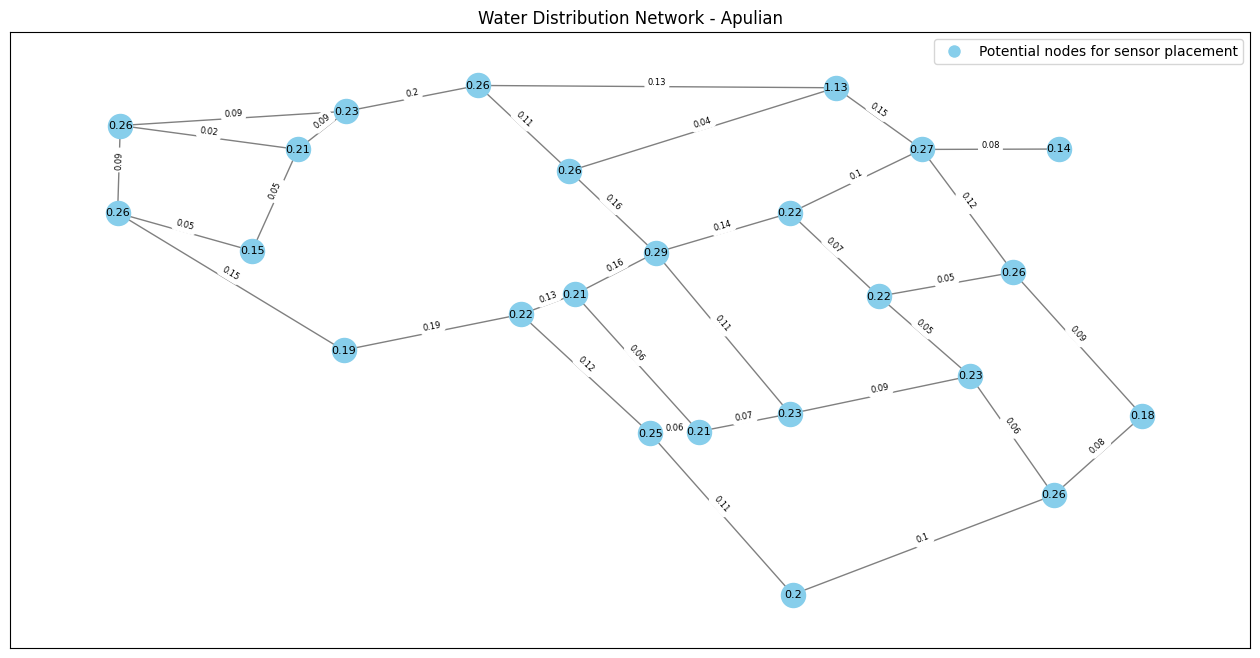

In [28]:
city = "Apulian"
plot_WDN(city)

The solution to this graph problem is explored using different reformulations of the problem.

First, we formulate the graph optimization problem as a Mixed Integer Program (MIQP):

$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} & \sum c_{i}x_{i} + \sum k_{ij} \\
    \textrm{s.t.} & \sum x_{i} = s \\
                  &  k_{ij} = w_{ij}(1 - x_{j} - x_{i} + z_{ij}) \\
                  &  z_{ij} \le 1 - x_{i} - x_{j} \\
                  &  z_{ij} \le x_{i} \\
                  &  z_{ij} \le x_{j} \\
\end{array}
$$

Here, $c_{i}$ represents the cost of the $i^{th}$ node, $w_{ij}$ represents the weight corresponding to the edge between nodes $i$ and $j$, and $x \in \{0, 1\}^{n}$ is a binary decision variable that indicates whether a sensor is placed at the $i^{th}$ node. $s$ is the predefined total number of sensors.

Next, the graph optimization problem is formulated as a Mixed Integer Quadratic Program (MIQP), following the approach of Speziali et al. (2021):

$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} & \sum c_{i}x_{i} + w_{ij}(1 - x_{j} - x_{i} + x_{i}x_{j}) \\
    \textrm{s.t.} & \sum x_{i} = s
\end{array}
$$

Finally, the Quadratic Unconstrained Binary Optimzation (QUBO) formulation of the graph problem is explored. Consider the MIQP model from before,
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} & \sum c_{i}x_{i} + w_{ij}(1 - x_{j} - x_{i} + x_{i}x_{j}) \\
    \textrm{s.t.} & \sum x_{i} = s
\end{array}
$$
To implement the problem as a QUBO, the constrianed should be lifted up into the objective function such that the problem becomes unconstrained. This is performed as follows:
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} & \sum c_{i}x_{i} + w_{ij}(1 - x_{j} - x_{i} + x_{i}x_{j}) + \rho(\sum (x_{i} - s)^2) \\
\end{array}
$$
where $\rho$ is a penalty term. Further simplification leads to
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} & \sum c_{i}x_{i} + w_{ij} - w_{ij}x_{j} - w_{ij}x_{i} + w_{ij}x_{i}x_{j} + \rho\sum x_{i}^2 - 2\rho\sum x_{i}s + \rho s^2 \\
\end{array}
$$
Since, $x_{i}$ is a binary variable, we can approximate (linearize) $x_{i}^2$ as $x_{i}$. Taking this into account and performing some algebraic manipulations, we have our QUBO problem.
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} \left( \sum_{i} (c_i + \rho - 2\rho s)x_i + \sum_{(i,j)}{w_{ij}} - \sum_{(i,j)} w_{ij}x_i - \sum_{(i,j)} w_{ij}x_j + \sum_{(i,j)} w_{ij}x_i x_j + \rho s^2 \right) \\
\end{array}
$$
where $s$ is the total number of sensors that is predefined.

In [29]:
def create_model(city, s, problem_type):  # Adding problem_type as a parameter
    G = Construct_Graph(city)
    if G is None:
        print(f"{city} does not exist.")
        return None

    water_consumption = water_consumption_Ap if city == "Apulian" else water_consumption_Fo  # water consumption data

    VC, EB = centrality(G, water_consumption)  # Calling edge_betweenness and vertex cost for edge weights and node demands 

    # Create a pyomo model
    model = pyo.ConcreteModel()

    # Define pyomo sets for graph G
    nodes = list(G.nodes())
    edges = list(G.edges())
    model.nodes = pyo.Set(initialize=nodes)
    model.edges = pyo.Set(initialize=edges, dimen=2)

    # Parameters
    demand = water_consumption
    model.demand = pyo.Param(model.nodes, initialize=demand, mutable=True)
    model.c = pyo.Param(model.nodes, initialize=VC, mutable=True)  # vertex cost
    model.k = pyo,Param(model.edges, initialize=EB, mutable=True)  # Substitute variable
    model.w = pyo.Param(model.edges, initialize=EB, mutable=True)  # edge_betweenness for edge weights

    # Binary decision variable
    model.x = pyo.Var(model.nodes, within=pyo.Binary)

    # Objective
    if problem_type == 'MIP1':
        # Define objective function
        def objective_rule(model):
            return sum(model.c[i] * model.x[i] for i in model.nodes) + \
                   sum(model.k[(i,j)] for (i, j) in model.edges)
        
        model.obj = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

        # Constraints
        def sensor_constraint_rule(model):
             sum(model.x[i] for i in model.nodes) == s

        model.sensor_constraint = pyo.Constraint(rule=sensor_constraint_rule)

    if problem_type == 'MIQP':
        # Define objective function
        def objective_rule(model):
            return sum(model.c[i] * model.x[i] for i in model.nodes) + \
                   sum(model.w[(i, j)] * (1 - model.x[i] - model.x[j] + model.x[i] * model.x[j]) for (i, j) in model.edges)

        model.obj = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

        # Constraints
        def sensor_constraint_rule(model):
            return sum(model.x[i] for i in model.nodes) == s

        model.sensor_constraint = pyo.Constraint(rule=sensor_constraint_rule)

    elif problem_type == 'QUBO':
        # Define objective function (example)
        def objective_rule(model):
            term1 = sum(model.c[i] * model.x[i] for i in model.nodes)
            term2 = sum(model.w[(i, j)] * (1 - model.x[i]) * (1 - model.x[j]) for (i, j) in model.edges)
            term3 = (sum(model.x[i] for i in model.nodes) - s) ** 2
            return term1 + term2 + term3

        model.obj = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

        # No constraints for QUBO 
    else:
        print(f"Unsupported problem type: {problem_type}")
        return None

    return model


In [30]:
# Select your city, model and number of sensors:
city = "Apulian"
problem_type = "QUBO"
s = 10
model = create_model(city, s, problem_type)

In [31]:
# Solve
solver = pyo.SolverFactory('gurobi', solver_io='python')
results = solver.solve(model, tee=True)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 0 rows, 24 columns and 0 nonzeros


Model fingerprint: 0xe68c93a6
Model has 300 quadratic objective terms
Variable types: 0 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [2e+01, 2e+01]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 103.4021739
Found heuristic solution: objective 2.5656552
Presolve time: 0.01s
Presolved: 276 rows, 300 columns, 828 nonzeros
Variable types: 0 continuous, 300 integer (300 binary)

Root relaxation: objective -1.248497e+02, 37 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -124.84965    0   24    2.56566 -124.84965  4966%     -    0s
     0     0  -42.20020    0  143    2.56566  -42.20020  1745%     -    0s
     0     0  -26.63061    0  193    2.56566  -26.63061  1138%     -    0s


In [32]:
# Print results
for node in model.nodes:
    print(f"Node {node}: Sensor placed = {pyo.value(model.x[node])}")

sensor_placement = {node: pyo.value(model.x[node]) for node in model.nodes}

Node J-1: Sensor placed = 1.0
Node J-2: Sensor placed = 0.0
Node J-3: Sensor placed = 1.0
Node J-4: Sensor placed = 0.0
Node J-5: Sensor placed = 0.0
Node J-6: Sensor placed = 1.0
Node J-7: Sensor placed = 0.0
Node J-8: Sensor placed = 1.0
Node J-9: Sensor placed = 0.0
Node J-10: Sensor placed = 0.0
Node J-11: Sensor placed = 1.0
Node J-12: Sensor placed = 0.0
Node J-13: Sensor placed = 1.0
Node J-14: Sensor placed = 0.0
Node J-15: Sensor placed = 1.0
Node J-16: Sensor placed = 0.0
Node J-17: Sensor placed = 1.0
Node J-18: Sensor placed = 0.0
Node J-19: Sensor placed = 0.0
Node J-20: Sensor placed = 1.0
Node J-21: Sensor placed = 0.0
Node J-22: Sensor placed = 0.0
Node J-23: Sensor placed = 1.0
Node T-1: Sensor placed = 0.0


In [33]:
# Plot sensor placement
def plot_sensor_placement(city, sensor_placement):
    
    G = Construct_Graph(city)
    if G is None:
        print(f"Graph could not be constructed for {city}.")
        return

    # Select water consumption data
    water_consumption = water_consumption_Ap if city == "Apulian" else water_consumption_Fo

    VC, EB = centrality(G, water_consumption)

    pos = nx.get_node_attributes(G, 'pos')

    # Create plot
    plt.figure(figsize=(16, 8))
    
    # Determine node colors based on sensor placement
    node_colors = ['red' if sensor_placement.get(node, 0) == 1 else 'skyblue' for node in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    #nx.draw_networkx_labels(G, pos, font_size=6, font_color='black')

    # Round off edge and node labels to two decimals for the plot
    edge_labels_rounded = {k: round(v, 2) for k, v in EB.items()}
    node_labels_rounded = {k: round(v, 2) for k, v in VC.items()}

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels_rounded, label_pos=0.5, font_size=6, verticalalignment='bottom')
    nx.draw_networkx_labels(G, pos, labels=node_labels_rounded, font_size=8, font_color='black')

    # Add legend
    red_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Sensor placed')
    blue_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue', markersize=10, label='No sensor')
    plt.legend(handles=[red_patch, blue_patch], loc='best')

    plt.title(f"Water Distribution Network - {city}")
    plt.show()

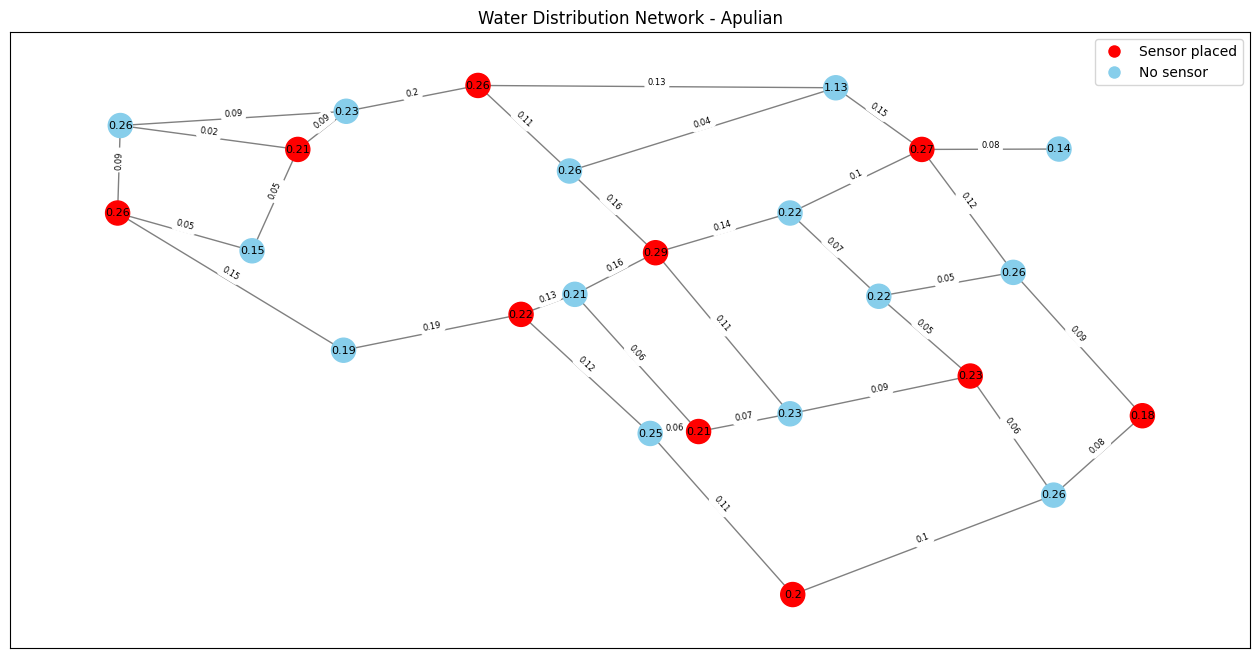

In [34]:
plot_sensor_placement(city, sensor_placement)

## Simulated Annealing:
 First, we build the adjacency matrix $Q$ that is obtained from the QUBO model. Remember that the QUBO problem is formulated as follows: 
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} \left( \sum_{i} (c_i + \rho - 2\rho s)x_i + \sum_{(i,j)}{w_{ij}} - \sum_{(i,j)} w_{ij}x_i - \sum_{(i,j)} w_{ij}x_j + \sum_{(i,j)} w_{ij}x_i x_j + \rho s^2 \right) \\
\end{array}
$$
where $s$ is the total number of sensors that is predefined. And, We know that in general, a QUBO problem is defined as: 
$$
\min_{x \in \{0,1 \}^n} \sum_{(ij) \in E(G)} Q_{ij}x_i x_j + \sum_{i \in V(G)}Q_{ii}x_i + c_Q = \min_{x \in \{0,1 \}^n}  x^\top Q x + c_Q
$$
where we optimize over binary variables $x \in \{ 0,1 \}^n$, on a constrained graph $G(V,E)$ defined by an adjacency matrix $Q$. We also include an arbitrary offset  $c_Q$.

Now we reformulate the QUBO into standard form
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x}  C^{T}x \\
    s.t.  Ax = b \\
          x \in \{0,1 \}^{n}
\end{array}
$$

Comparing the above problems, it is evident that 
$$
\begin{array}{rl}
    \displaystyle%
    Q_{ii} = (c_{i} + \rho -2\rho s) - \sum_{j}w_{ij} \\
    
    Q_{ij} = w_{ij}
\end{array}
$$

In [39]:
def calculate_Q_matrix(city, s):
    # Construct the graph
    G = Construct_Graph(city)
    if G is None:
        return None
    
    # Get water consumption data for the city
    water_consumption = water_consumption_Ap if city == "Apulian" else water_consumption_Fo
    
    # Calculate centrality measures
    vertex_cost, edge_betweenness = centrality(G, water_consumption)
    
    # Initialize the Q matrix
    n = len(G.nodes)
    Q = np.zeros((n, n))
    
    # Mapping nodes to indices
    node_to_index = {node: i for i, node in enumerate(G.nodes)}
    
    # Fill the Q matrix
    for (u, v), w in edge_betweenness.items():
        i = node_to_index[u]
        j = node_to_index[v]
        if i != j:
            Q[i, j] = w  # Off diagonal quadratic term
            Q[j, i] = w  # Since Q is symmetric            

    for node, C in vertex_cost.items():
        k = node_to_index[node]
        sum_w = sum(edge_betweenness.get((min(node, neighbor), max(node, neighbor)), 0) for neighbor in G.neighbors(node))
        Q[k, k] = (C + 1 - 2 * s) - sum_w
    
    return Q

In [40]:
city = "Apulian"
s = 10
Q = calculate_Q_matrix(city, s)
print("Q matrix for the QUBO formulation:")
print(Q)

Q matrix for the QUBO formulation:
[[-1.91882195e+01  1.52596618e-01  0.00000000e+00  0.00000000e+00
   9.57125604e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.23309179e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  8.33333333e-02]
 [ 1.52596618e-01 -1.81952899e+01  1.30253623e-01  4.28743961e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.30253623e-01 -1.91913671e+01  1.14432367e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.04830918e-01  0.00000000e+00  0.00

In [20]:
# Binary Quadratic Model
#bqm = dimod.BinaryQuadraticModel.from_qubo(Q)

# Use ExactSolver to sample the BQM
#exactSampler = dimod.reference.samplers.ExactSolver()
#exactSamples = exactSampler.sample(bqm)

# Print the sample results
#print("Exact Solver Samples:")
#print(exactSamples)

# If you want to extract and process the samples:
#for sample, energy in exactSamples.data(['sample', 'energy']):
    #print(sample, "Energy:", energy)

In [41]:
# Some useful functions to get plots
def plot_enumerate(results, title=None):

    plt.figure()

    energies = [datum.energy for datum in results.data(
        ['energy'], sorted_by='energy')]

    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    plt.bar(samples,energies)
    plt.xticks(rotation=90)
    plt.ylabel('Energy')
    plt.title(str(title))
    print("minimum energy:", min(energies))

def plot_samples(results, title=None):
    plt.figure()
    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    counts = Counter(samples)
    total = len(samples)
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None)

    plt.xticks(rotation=80)
    plt.ylabel('Probabilities')
    plt.title(str(title))
    plt.show()
    print("minimum energy:", min(energies))


def plot_energies(results, title=None, skip=1):
    # skip parameter given to avoid putting all xlabels
    energies = results.data_vectors['energy']
    occurrences = results.data_vectors['num_occurrences']
    counts = Counter(energies)
    total = sum(occurrences)
    counts = {}
    for index, energy in enumerate(energies):
        if energy in counts.keys():
            counts[energy] += occurrences[index]
        else:
            counts[energy] = occurrences[index]
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    ax = df.plot(kind='bar', legend=None)

    plt.xlabel('Energy')
    plt.ylabel('Probabilities')
    # Plot only a subset of xlabels (every skip steps)
    ax.set_xticklabels([t if not i%skip else "" for i,t in enumerate(ax.get_xticklabels())])
    plt.title(str(title))
    plt.show()
    print("minimum energy:", min(energies))

minimum energy: -447.2357782027751


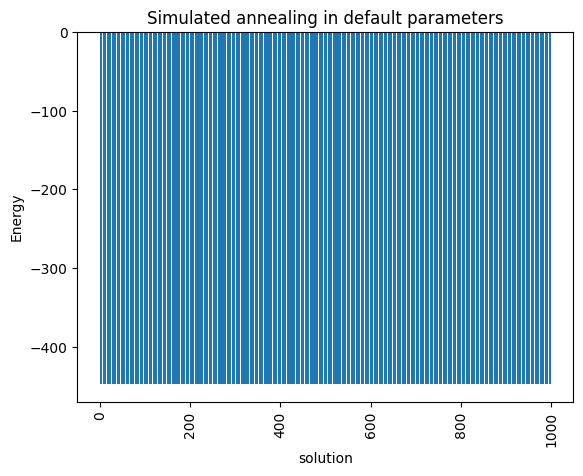

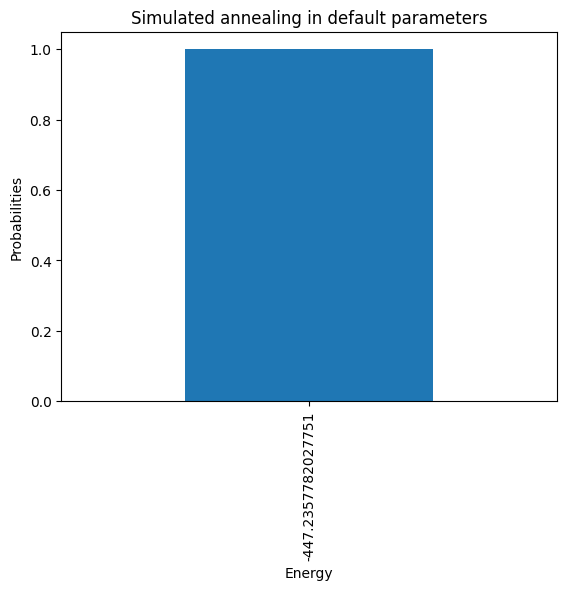

minimum energy: -447.2357782027751


{'beta_range': [0.03611765523808619, 297.4241884407982],
 'beta_schedule_type': 'geometric',
 'timing': {'preprocessing_ns': 38583904,
  'sampling_ns': 370266849,
  'postprocessing_ns': 2790707}}

In [43]:
# Simulated Annealing

beta = 1 #offset
mod = dimod.BinaryQuadraticModel.from_qubo(Q, offset=beta)

simAnnSampler = neal.SimulatedAnnealingSampler()
simAnnSamples = simAnnSampler.sample(mod, num_reads=1000)
plot_enumerate(simAnnSamples, title='Simulated annealing in default parameters')
plot_energies(simAnnSamples, title='Simulated annealing in default parameters')
simAnnSamples.info

In [44]:
plot_enumerate(exactSamples, title='Enumerate all solutions')
plot_energies(exactSamples, title='Enumerate all solutions', skip=10)

NameError: name 'exactSamples' is not defined

Let's now solve this QUBO via traditional Integer Programming.

In [ ]:
# We do not need to worry about the tranformation to QUBO since dimod takes care of it
Q, c = model.to_qubo()

# Define the model
model_pyo = pyo.ConcreteModel(name='QUBO example as an IP, 47-779/785 QuIPML')

I = range(len(model))
J = range(len(model))
#Define the original variables
model_pyo.x = pyo.Var(I, domain=pyo.Binary)
# Define the edges variables
model_pyo.y = pyo.Var(I, J, domain=pyo.Binary)

obj_expr = c

# add model constraints
model_pyo.c1 = pyo.ConstraintList()  
model_pyo.c2 = pyo.ConstraintList()
model_pyo.c3 = pyo.ConstraintList()
for (i,j) in Q.keys():
    if i != j:
        model_pyo.c1.add(model_pyo.y[i,j] >= model_pyo.x[i] + model_pyo.x[j] - 1)
        model_pyo.c2.add(model_pyo.y[i,j] <= model_pyo.x[i])
        model_pyo.c3.add(model_pyo.y[i,j] <= model_pyo.x[j])
        obj_expr += Q[i,j]*model_pyo.y[i,j]
    else:
        obj_expr += Q[i,j]*model_pyo.x[i]

# Define the objective function
model_pyo.objective = pyo.Objective(expr = obj_expr, sense=pyo.minimize)
# Print the model
model_pyo.display()

Let's install the MIP solver GLPK

In [ ]:
# Let's install the LP/MIP solver GLPK
if IN_COLAB:
    !apt-get install -y -qq glpk-utils

In [ ]:
# Define the solver GLPK
if IN_COLAB:
    opt_glpk = pyo.SolverFactory('glpk', executable='/usr/bin/glpsol')
else:
    opt_glpk = pyo.SolverFactory('glpk')
# Here we could use another solver, e.g. gurobi or cplex
# opt_gurobi = pyo.SolverFactory('gurobi')

In [ ]:
# We obtain the solution with GLPK
result_obj = opt_glpk.solve(model_pyo, tee=False)
model_pyo.display()

We observe that the optimal solution of this problem is $x_{8} = 1, 0$ otherwise, leading to an objective of $5$. Notice that this problem has a degenerate optimal solution given that $x_{10} = 1, 0$ otherwise also leads to the same solution.

## Ising model
This notebook will explain the basics of the Ising model. In order to implement the different Ising Models we will use D-Wave's packages **[dimod](https://github.com/dwavesystems/dimod)** and **[neal](https://github.com/dwavesystems/dwave-neal)**, for defining the Ising model and solving it with simulated annealing, respectively. When posing the problems as Integer programs, we will model using **[Pyomo](http://www.pyomo.org/)**, an open-source Python package, which provides a flexible access to different solvers and a general modeling framework for linear and nonlinear integer programs.
The examples solved here will make use of open-source solver **[GLPK](https://www.gnu.org/software/glpk/)** for mixed-integer linear programming.

#### Problem statement
We pose the Ising problem as the following optimization problem:
$$
\min_{\sigma \in \{ -1,+1 \}^n} H(\sigma) =\min_{\sigma \in \{ -1,+1 \}^n} \sum_{(ij) \in E(G)} J_{ij}\sigma_i\sigma_j + \sum_{i \in V(G)}h_i\sigma_i + c_I
$$
where we optimize over spins $\sigma \in \{ -1,+1 \}^n$, on a constrained graph $G(V,E)$, where the quadratic coefficients are $J_{ij}$ and the linear coefficients are $h_i$. We also include an arbitrary offset of the Ising model $c_I$.

### Example

Suppose we have an Ising model defined from

$$
h = \begin{bmatrix}
145.0 \\ 122.0 \\ 122.0 \\ 266.0 \\ 266.0 \\ 266.0 \\ 242.5 \\ 266.0 \\ 386.5 \\ 387.0 \\ 386.5
\end{bmatrix},
J = \begin{bmatrix}
0 & 0 & 0 & 24 & 24 & 24 & 24 & 24 & 24 & 24 & 24\\
0 & 0 & 0 & 24 & 0 & 24 & 24 & 24 & 24 & 24 & 24\\
0 & 0 & 0 & 0 & 24 & 0 & 24 & 24 & 24 & 24 & 24\\
0 & 0 & 0 & 0 & 24 & 48 & 24 & 24 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 24 & 24 & 48 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 24 & 24 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 24 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 72 & 72\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 72\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
\end{bmatrix} \text{ and }
\beta = 1319.5
$$
Let's solve this problem

In [ ]:
# These could also be simple lists and numpy matrices
h = {0: 145.0, 1: 122.0, 2: 122.0, 3: 266.0, 4: 266.0, 5: 266.0, 6: 242.5, 7: 266.0, 8: 386.5, 9: 387.0, 10: 386.5}
J = {(0, 3): 24.0, (0, 4): 24.0, (0, 5): 24.0, (0, 7): 24.0, (0, 8): 24.0, (0, 9): 24.0, (0, 10): 24.0, (1, 3): 24.0, (1, 5): 24.0, (1, 6): 24.0, (1, 8): 24.0, (1, 9): 24.0, (1, 10): 24.0, (2, 4): 24.0, (2, 6): 24.0, (2, 7): 24.0, (2, 8): 24.0, (2, 9): 24.0, (2, 10): 24.0, (3, 4): 24.0, (3, 5): 48.0, (3, 6): 24.0, (3, 7): 24.0, (3, 8): 48.0, (3, 9): 48.0, (3, 10): 48.0, (4, 5): 24.0, (4, 6): 24.0, (4, 7): 48.0, (4, 8): 48.0, (4, 9): 48.0, (4, 10): 48.0, (5, 6): 24.0, (5, 7): 24.0, (5, 8): 48.0, (5, 9): 48.0, (5, 10): 48.0, (6, 7): 24.0, (6, 8): 48.0, (6, 9): 48.0, (6, 10): 48.0, (7, 8): 48.0, (7, 9): 48.0, (7, 10): 48.0, (8, 9): 72.0, (8, 10): 72.0, (9, 10): 72.0}
cI = 1319.5

model_ising = dimod.BinaryQuadraticModel.from_ising(h, J, offset=cI)

Since the problem is relatively small (11 variables, $2^{11}=2048$ combinations), we can afford to enumerate all the solutions.

In [ ]:
exactSamples = exactSampler.sample(model_ising)

In [ ]:
plot_enumerate(exactSamples, title='Enumerate all solutions')
plot_energies(exactSamples, title='Enumerate all solutions')

Let's now solve this Ising Model via traditional Integer Programming.

In [ ]:
# We do not need to worry about the tranformation from Ising to QUBO since dimod takes care of it
Q, c = model_ising.to_qubo()

# Define the model
model_ising_pyo = pyo.ConcreteModel(name='Ising example as an IP, 47-779/785 QuIPML')

I = range(len(h))
J = range(len(h))
#Define the original variables
model_ising_pyo.x = pyo.Var(I, domain=pyo.Binary)
# Define the edges variables
model_ising_pyo.y = pyo.Var(I, J, domain=pyo.Binary)

obj_expr = c

# add model constraints
model_ising_pyo.c1 = pyo.ConstraintList()
model_ising_pyo.c2 = pyo.ConstraintList()
model_ising_pyo.c3 = pyo.ConstraintList()
for (i,j) in Q.keys():
    if i != j:
        model_ising_pyo.c1.add(model_ising_pyo.y[i,j] >= model_ising_pyo.x[i] + model_ising_pyo.x[j] - 1)
        model_ising_pyo.c2.add(model_ising_pyo.y[i,j] <= model_ising_pyo.x[i])
        model_ising_pyo.c3.add(model_ising_pyo.y[i,j] <= model_ising_pyo.x[j])
        obj_expr += Q[i,j]*model_ising_pyo.y[i,j]
    else:
        obj_expr += Q[i,j]*model_ising_pyo.x[i]

# Define the objective function
model_ising_pyo.objective = pyo.Objective(expr = obj_expr, sense=pyo.minimize)
# Print the model
model_ising_pyo.display()

In [ ]:
# We obtain the solution with GLPK
result_obj = opt_glpk.solve(model_ising_pyo, tee=False)
model_ising_pyo.display()

We observe that the optimal solution of this problem is $x_{10} = 1, 0$ otherwise, leading to an objective of $5$. Notice that this problem has a degenerate optimal solution given that $x_8 = 1, 0$ otherwise also leads to the same solution.

## Let's go back to the slides

We can also solve this problem using Simulated Annealing

In [ ]:
simAnnSampler = neal.SimulatedAnnealingSampler()
simAnnSamples = simAnnSampler.sample(model_ising, num_reads=1000)

In [ ]:
plot_enumerate(simAnnSamples, title='Simulated annealing in default parameters')
plot_energies(simAnnSamples, title='Simulated annealing in default parameters')

In [ ]:
simAnnSamples.info

## Let's go back to the slides

Let's solve the graph coloring problem in the slides using QUBO.

#### Vertex $k$-coloring of graphs

Given a graph $G(V, E)$, where $V$ is the set of vertices and $E$ is the set of edges of $G$, and a positive integer $k$, we ask if it is possible to assign a color to every vertex from $V$, such that adjacent vertices have different colors assigned.

$G(V, E)$ has $12$ vertices and $23$ edges.
We ask if the graph is $3$–colorable.
Let’s first encode $V$ and $E$ using Julia’s built–in data structures:

**Note:** This tutorial is heavily inspired in D-Wave's Map coloring of Canada found **[here](https://docs.ocean.dwavesys.com/en/stable/examples/map_coloring.html)**.

In [ ]:
# Let's install with dimod and neal
!pip install dwavebinarycsp
!pip install dwavebinarycsp[maxgap]
!pip install dwavebinarycsp[mip]

import dwavebinarycsp

In [ ]:
V = range(1, 12+1)
E = [(1,2),(2,3),(1,4),(1,6),(1,12),(2,5),(2,7),(3,8),(3,10),(4,11),(4,9),(5,6),(6,7),(7,8),(8,9),(9,10),(10,11),(11,12),(5,12),(5,9),(6,10),(7,11),(8,12)]
layout = {i: [np.cos((2*i+1)*np.pi/8),np.sin((2*i+1)*np.pi/8)] for i in np.arange(5,13)}
layout[1] = [-1.5,1.5]
layout[2] = [1.5,1.5]
layout[3] = [1.5,-1.5]
layout[4] = [-1.5,-1.5]
G = nx.Graph()
G.add_edges_from(E)
nx.draw(G, with_labels=True, pos=layout)

In [ ]:
# Function for the constraint that two nodes with a shared edge not both select
# one color
def not_both_1(v, u):
    return not (v and u)

# Valid configurations for the constraint that each node select a single color, in this case we want to use 3 colors
one_color_configurations = {(0, 0, 1), (0, 1, 0), (1, 0, 0)}
colors = len(one_color_configurations)

# Create a binary constraint satisfaction problem
csp = dwavebinarycsp.ConstraintSatisfactionProblem(dwavebinarycsp.BINARY)

# Add constraint that each node select a single color
for node in V:
    variables = ['x'+str(node)+','+str(i) for i in range(colors)]
    csp.add_constraint(one_color_configurations, variables)

# Add constraint that each pair of nodes with a shared edge not both select one color
for edge in E:
    v, u = edge
    for i in range(colors):
        variables = ['x'+str(v)+','+str(i), 'x'+str(u)+','+str(i)]
        csp.add_constraint(not_both_1, variables)

Defining the Binary Quandratic model (QUBO) using the CSP library we have:

In [ ]:
bqm = dwavebinarycsp.stitch(csp)
simAnnSamples = simAnnSampler.sample(bqm, num_reads=1000)

In [ ]:
plot_enumerate(simAnnSamples, title='Simulated annealing in default parameters')
plot_energies(simAnnSamples, title='Simulated annealing in default parameters')

Because of precision issues in the translation to BQM, we *may* obtain very tiny coefficeints that should be zero. In any case, since this is a constraint satisfaction problem, any of the solutions with energy ~0 is a valid coloring.

In [ ]:
# Check that a good solution was found
sample = simAnnSamples.first.sample     # doctest: +SKIP
if not csp.check(sample):           # doctest: +SKIP
        print("Failed to color map. Try sampling again.")
else:
        print(sample)

In [ ]:
# Function that plots a returned sample
def plot_map(sample):
    # Translate from binary to integer color representation
    color_map = {}
    for node in V:
          for i in range(colors):
            if sample['x'+str(node)+','+str(i)]:
                color_map[node] = i
    # Plot the sample with color-coded nodes
    node_colors = [color_map.get(node) for node in G.nodes()]
    nx.draw(G, with_labels=True, pos=layout, node_color=node_colors)
    plt.show()

In [ ]:
plot_map(sample)